# Virtual Lead Qualifier – Lead Scoring Model (With Feature Importance)

End-to-end ML pipeline with explainability

## 1. Imports

In [55]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score
)


## 2. Load Dataset

In [4]:

df = pd.read_csv("Lead Scoring.csv")
df.head()


,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## 3. Drop Non-Predictive Columns

In [7]:

df.drop(columns=["Prospect ID", "Lead Number", "Lead Quality"], inplace=True)


## 4. Handle Missing Values

In [10]:

df["TotalVisits"] = df["TotalVisits"].fillna(df["TotalVisits"].median())
df["Page Views Per Visit"] = df["Page Views Per Visit"].fillna(df["Page Views Per Visit"].median())
df["Asymmetrique Activity Score"] = df["Asymmetrique Activity Score"].fillna(df["Asymmetrique Activity Score"].median())
df["Asymmetrique Profile Score"] = df["Asymmetrique Profile Score"].fillna(df["Asymmetrique Profile Score"].median())

cat_fill_cols = [
    "Last Activity", "Country", "Specialization",
    "How did you hear about X Education",
    "What is your current occupation",
    "What matters most to you in choosing a course",
    "Lead Profile", "City"
]

for col in cat_fill_cols:
    df[col] = df[col].fillna("Unknown")


## 5. Binary Encoding

In [13]:

binary_cols = [
    "Do Not Email", "Do Not Call", "Search", "Magazine",
    "Newspaper Article", "X Education Forums", "Newspaper",
    "Digital Advertisement", "Through Recommendations",
    "Receive More Updates About Our Courses",
    "Update me on Supply Chain Content", "Get updates on DM Content",
    "I agree to pay the amount through cheque",
    "A free copy of Mastering The Interview"
]

for col in binary_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})


## 6. Lead Source Grouping

In [16]:

df["Lead Source"] = df["Lead Source"].fillna(df["Lead Source"].mode()[0])

top_sources = ["Google", "Direct Traffic", "Organic Search", "Facebook", "Olark Chat"]

df["Lead Source"] = df["Lead Source"].apply(
    lambda x: x if x in top_sources else "Other"
)


## 7. Tags to Intent Group

In [19]:
def tag_group(tag):
    if pd.isna(tag):
        return "Unknown"
    elif "Interested" in tag:
        return "High Intent"
    elif tag in ["Busy", "Ringing"]:
        return "Medium Intent"
    else:
        return "Low Intent"

df["Tag_Group"] = df["Tags"].apply(tag_group)
df.drop(columns=["Tags"], inplace=True)

## 8. Drop Redundant Index Columns

In [22]:

df.drop(columns=[
    "Asymmetrique Activity Index",
    "Asymmetrique Profile Index"
], inplace=True)


## 9. Train-Test Split

In [25]:

X = df.drop("Converted", axis=1)
y = df["Converted"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


## 10. Preprocessing & Model Pipeline

In [28]:

categorical_cols = X.select_dtypes(include="object").columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])

clf = Pipeline([
    ("preprocessing", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])


## 11. Train Model

In [31]:

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['Lead Origin', 'Lead Source', 'Last Activity', 'Country',
       'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Lead Profile', 'City',
       'Last Notable Activity', 'Tag_Gr...
       'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

## 12. Model Evaluation

In [59]:

y_prob = clf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


ROC-AUC: 0.9576412516924266
[[1587  117]
 [ 166  902]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1704
           1       0.89      0.84      0.86      1068

    accuracy                           0.90      2772
   macro avg       0.90      0.89      0.89      2772
weighted avg       0.90      0.90      0.90      2772



## 13. ROC Curve

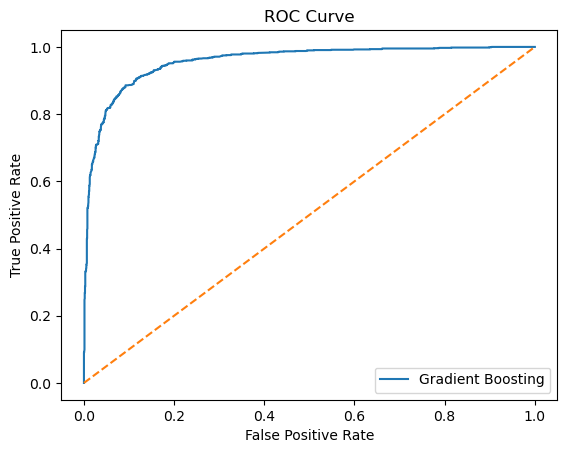

In [37]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Gradient Boosting")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## 14. Feature Importance (Explainability)

In [40]:
# Get feature names after preprocessing
cat_features = clf.named_steps["preprocessing"]     .named_transformers_["cat"]     .get_feature_names_out(categorical_cols)

feature_names = np.concatenate([cat_features, numeric_cols])

importances = clf.named_steps["model"].feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df.head(15)


,Feature,Importance
117,Tag_Group_Low Intent,0.310625
123,Total Time Spent on Website,0.150773
114,Last Notable Activity_SMS Sent,0.102739
1,Lead Origin_Lead Add Form,0.092847
118,Tag_Group_Medium Intent,0.069083
135,Asymmetrique Activity Score,0.049099
95,Lead Profile_Potential Lead,0.040664
97,Lead Profile_Student of SomeSchool,0.034469
90,What is your current occupation_Working Profes...,0.019710
119,Tag_Group_Unknown,0.015669


## 15. Top 10 Important Features

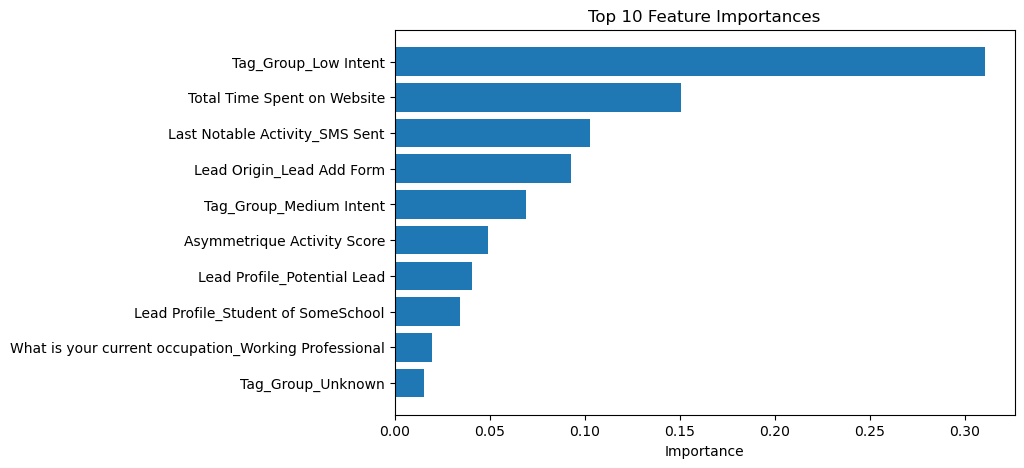

In [42]:
top_features = feature_importance_df.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_features["Feature"], top_features["Importance"])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.show()


## 16. Threshold Optimization

In [45]:
thresholds = np.arange(0.3, 0.9, 0.05)
rows = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    rows.append({
        "Threshold": t,
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds)
    })

threshold_df = pd.DataFrame(rows)
threshold_df


,Threshold,Precision,Recall,F1
0,0.30,0.800651,0.921348,0.856770
1,0.35,0.830319,0.902622,0.864962
2,0.40,0.861878,0.876404,0.869081
3,0.45,0.874046,0.857678,0.865784
4,0.50,0.885182,0.844569,0.864399
5,0.55,0.899177,0.818352,0.856863
6,0.60,0.914317,0.789326,0.847236
7,0.65,0.925592,0.768727,0.839898
8,0.70,0.932464,0.736891,0.823222
9,0.75,0.943467,0.703184,0.805794


## 17. Lead Scoring & Bucketing

In [50]:
lead_score = pd.Series((y_prob * 100).round(0), index=y_test.index)

def lead_bucket(score):
    if score >= 80:
        return "Hot Lead"
    elif score >= 60:
        return "Warm Lead"
    else:
        return "Cold Lead"

lead_bucketed = pd.DataFrame({
    "Lead_Score": lead_score,
    "Lead_Category": lead_score.apply(lead_bucket),
    "Actual_Converted": y_test
})

lead_bucketed.head()


,Lead_Score,Lead_Category,Actual_Converted
8305,5.0,Cold Lead,0
1591,90.0,Hot Lead,1
8604,78.0,Warm Lead,0
1333,4.0,Cold Lead,0
4260,2.0,Cold Lead,0


## 18. Save Model for Deployment

In [53]:
joblib.dump(clf, "lead_scoring_model.joblib")

['lead_scoring_model.joblib']